# [Computational Social Science] Project 4: Unsupervised Learning

**Enter your Name:**Nereida Heller

*Semester:* Fall 2024

FYI explanatory links in PDF are all deadends. I constructed a dataset through extensive googling and vlookup. It's in my repo, feel free to save it for future classes!

## Data Description and Preprocessing

For this project, you will explore data from the [National Health and Nutrition Examination Survey](https://www.kaggle.com/cdc/national-health-and-nutrition-examination-survey?select=questionnaire.csv). NHANES is a unique study that combines survey methodology with in-person medical examinations to create a dataset with demographic information, health indicators, and health outcomes.

We start by importing the data and doing some preliminary preprocessing for you. We import some libraries that will be helpful as well. 'SEQN' is the ID number for each respondent, and 'HSD010' will be our target outcome. [HSD010](https://wwwn.cdc.gov/Nchs/Nhanes/2013-2014/HSQ_H.htm#HSD010) asks for the respondent's self reported health condition, which can range from "excellent" to "poor."

In [1]:
# Import libraries
import pandas as pd
import numpy as np
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from keras.models import Sequential
from keras.layers import Dense, Dropout
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
from sklearn.model_selection import train_test_split
sns.set_style("darkgrid")
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.metrics import pairwise_distances_argmin_min

In [2]:
# Load nhanes data
nhanes = pd.read_csv('nhanes.csv')
# Get the ID numbers for each observation (seqn)
seqn = nhanes['SEQN']
# Get the target, "self-reported health condition," HSD010
hsd010 = nhanes['HSD010']
# Drop SEQN from the dataframe and then apply the standard scaler
nhanes = nhanes.drop(['SEQN', 'HSD010'], axis = 1)
nhanes_scaled = pd.DataFrame(StandardScaler().fit_transform(nhanes),
                             columns = nhanes.columns)
# Add the ID and target back in
nhanes_scaled['SEQN'] = seqn
nhanes_scaled['HSD010'] = hsd010
nhanes_scaled = nhanes_scaled.set_index('SEQN')
nhanes_scaled.head()

,DR1DRSTZ,DR1EXMER,DRABF,DRDINT,DR1DBIH,DR1DAY,DR1LANG,DR1MNRSP,DR1HELPD,DBQ095Z,...,OHQ770,OHQ845,PAAQUEX,SMQ860,SMQ870,SMQ872,SMQ874,SMQ878,SMAQUEX.x,HSD010
SEQN,,,,,,,,,,,,,,,,,,,,,
73568,0.0,2.034312,0.0,0.324834,-0.393906,1.085853,-0.194202,-0.057306,0.128246,-0.189513,...,0.383802,-0.646584,-0.484200,1.125008,0.0,-2.081666,1.087115,1.463404,0.612440,1
73576,0.0,0.261930,0.0,-3.078499,0.568251,0.634362,-0.194202,-0.057306,0.128246,0.080373,...,0.383802,-1.539259,-0.484200,1.125008,0.0,-2.081666,1.087115,-0.683338,-1.632812,1
73579,0.0,0.728346,0.0,0.324834,1.530407,-1.623092,-0.194202,-0.057306,0.128246,-0.189513,...,0.383802,-1.539259,2.065262,-0.888883,0.0,0.480384,-0.919866,-0.683338,-1.632812,2
73581,0.0,-0.857470,0.0,0.324834,0.480782,1.085853,-0.194202,-0.057306,0.128246,0.080373,...,0.383802,-0.646584,-0.484200,1.125008,0.0,0.480384,-0.919866,-0.683338,0.612440,2
73584,0.0,0.495138,0.0,0.324834,0.305844,-1.623092,-0.194202,-0.057306,0.128246,0.080373,...,-2.605509,0.246091,2.065262,1.125008,0.0,0.480384,-0.919866,1.463404,-1.632812,3


## Plots

Let's take a look at the data. Below we visualize boxplots of family income to federal poverty line ratio ('INDFMPIR') and self-reported health condition. Notice how there are some clear patterns (the lower the ratio, the lower reported health condition), but it's not a perfect separation. We have 240+ features in our dataset, and we likely have several features in our dataset that highly correlate with our family income-poverty line ratio measure - PCA will help us simplify these.

In [3]:
print(list(nhanes.columns))

['DR1DRSTZ', 'DR1EXMER', 'DRABF', 'DRDINT', 'DR1DBIH', 'DR1DAY', 'DR1LANG', 'DR1MNRSP', 'DR1HELPD', 'DBQ095Z', 'DRQSPREP', 'DR1STY', 'DRQSDIET', 'DR1TNUMF', 'DR1TKCAL', 'DR1TPROT', 'DR1TCARB', 'DR1TSUGR', 'DR1TFIBE', 'DR1TTFAT', 'DR1TSFAT', 'DR1TMFAT', 'DR1TPFAT', 'DR1TCHOL', 'DR1TATOC', 'DR1TRET', 'DR1TVARA', 'DR1TBCAR', 'DR1TLZ', 'DR1TVB1', 'DR1TVB2', 'DR1TNIAC', 'DR1TVB6', 'DR1TFOLA', 'DR1TFA', 'DR1TFF', 'DR1TFDFE', 'DR1TCHL', 'DR1TVB12', 'DR1TVC', 'DR1TVD', 'DR1TVK', 'DR1TCALC', 'DR1TPHOS', 'DR1TMAGN', 'DR1TIRON', 'DR1TZINC', 'DR1TCOPP', 'DR1TSODI', 'DR1TPOTA', 'DR1TSELE', 'DR1TMOIS', 'DR1TS040', 'DR1TS060', 'DR1TS080', 'DR1TS100', 'DR1TS120', 'DR1TS140', 'DR1TS160', 'DR1TS180', 'DR1TM161', 'DR1TM181', 'DR1TM201', 'DR1TP182', 'DR1TP183', 'DR1TP204', 'DR1.300', 'DR1TWS', 'DRD340', 'DRD360', 'PEASCST1', 'PEASCTM1', 'BPXPULS', 'BMDSTATS', 'BMXWT', 'BMXHT', 'BMXBMI', 'BMXARML', 'BMXARMC', 'BMXWAIST', 'MGDEXSTS', 'OHDEXSTS', 'OHDDESTS', 'OHX01TC', 'OHX02TC', 'OHX03TC', 'OHX04TC', 'OHX05

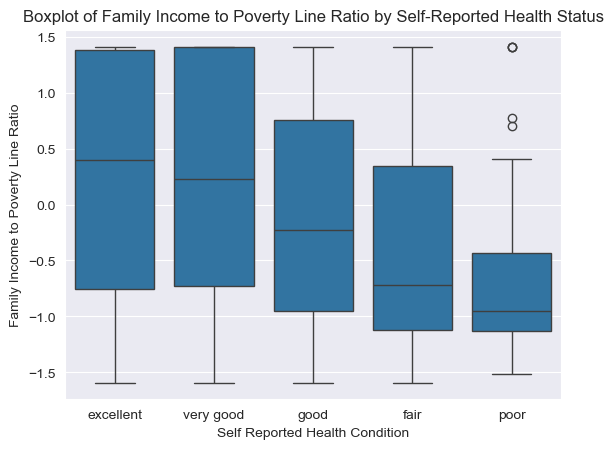

In [4]:
# Create a binary version of hsd010 where 1-3 are "good" and 4-5 are "poor"
nhanes_scaled['HSD010_binary'] = hsd010_binary = nhanes_scaled['HSD010'].replace(
    [1, 2, 3, 4, 5], ['good', 'good', 'good', 'poor', 'poor'])
# Recode the original hsd010 with the string labels
nhanes_scaled['HSD010'] = nhanes_scaled['HSD010'].replace(
    [1, 2, 3, 4, 5], ['excellent', 'very good', 'good', 'fair', 'poor'])
# Boxplot of hsd010
ax = sns.boxplot(x = 'HSD010', y = 'INDFMPIR', data = nhanes_scaled)
ax.set(xlabel = "Self Reported Health Condition",
      ylabel = "Family Income to Poverty Line Ratio")
ax.set_title("Boxplot of Family Income to Poverty Line Ratio by Self-Reported Health Status")
plt.show()

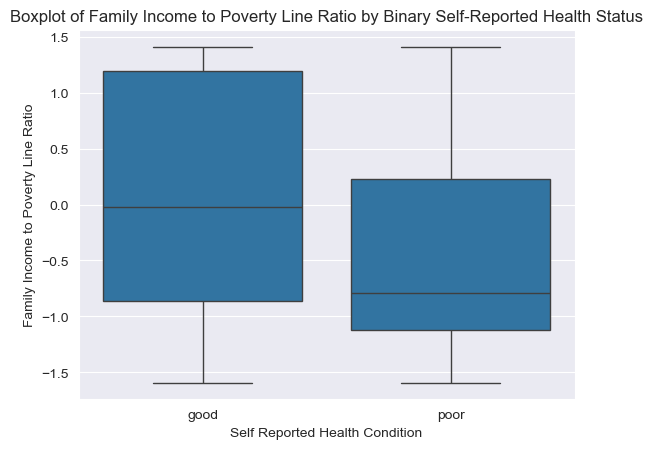

In [5]:
# Boxplot of hsd010_binary
ax = sns.boxplot(x = 'HSD010_binary', y = 'INDFMPIR', data = nhanes_scaled)
ax.set(xlabel = "Self Reported Health Condition",
      ylabel = "Family Income to Poverty Line Ratio")
ax.set_title("Boxplot of Family Income to Poverty Line Ratio by Binary Self-Reported Health Status")
plt.show()

Family income also is not necessarily well correlated with measured health outcomes. See below where we look at the relationship between Body Mass Index (BMI) and the family income-poverty line ratio, and shade points by self-reported health condition. It's hard to find a clear pattern - this is where clustering may come in handy. 

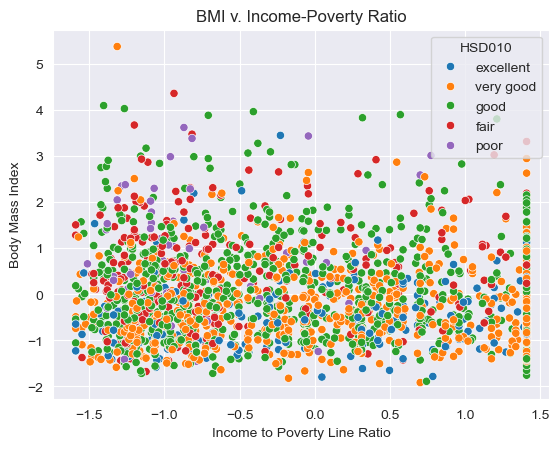

In [6]:
ax = sns.scatterplot(x = "INDFMPIR", y = "BMXBMI", hue = "HSD010", palette = "tab10", data = nhanes_scaled)
ax.set(xlabel = "Income to Poverty Line Ratio",
      ylabel = "Body Mass Index")
ax.set_title("BMI v. Income-Poverty Ratio")
plt.show()

Before we move to working on unsupervised methods, we'll drop our target variables again:

I don't understand how to do the analyses without the target. I'm creating a separate object where it's still linked. 

In [7]:
nhanes_scaled_target = nhanes_scaled
nhanes_scaled = nhanes_scaled.drop(['HSD010', 'HSD010_binary'], axis = 1)

In [8]:
nhanes_scaled_target['HSD010_binary']

SEQN
73568    good
73576    good
73579    good
73581    good
73584    good
         ... 
83694    good
83696    good
83704    poor
83716    good
83721    good
Name: HSD010_binary, Length: 2064, dtype: object

## Principal Component Analysis

Conduct a Principal Component Analysis (PCA) of the nhanes data. The data has already been prepared for you, so you can work directly on nhanes_scaled. Be sure to do the following:

- Choose the number of components and provide 1-2 sentences about your choice of the number of components. 
- Plot a barplot of the variation explained by each component. *Hint*: look at the attributes associated with your model. 
- Choose how many components you will use to fit a supervised learning model and provide 1-2 sentences to explain that choice.
- Plot a 2D scatterplot of the first two components and provide 1-2 sentences analyzing the plot.

### Train PCA and Discuss Number of Components

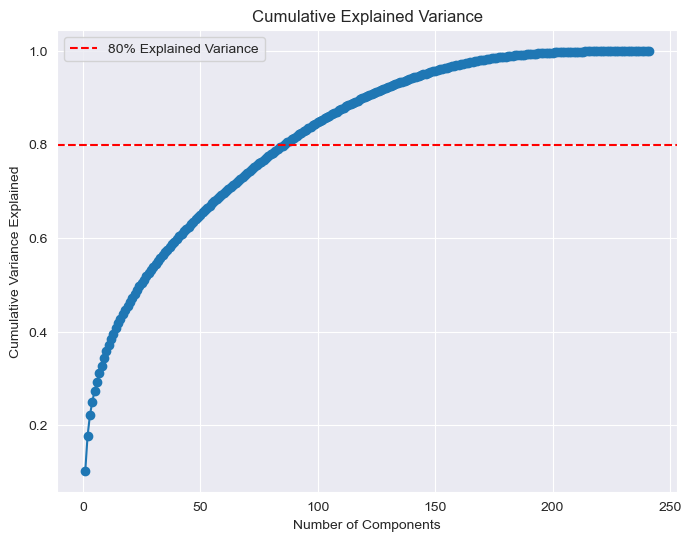

In [9]:
# 1. Fit PCA and choose the number of components
pca = PCA()
pca.fit(nhanes_scaled)

# Choosing number of components
explained_variance = np.cumsum(pca.explained_variance_ratio_)

explained_variance_ratio = pca.explained_variance_ratio_
# Cumulative explained variance
cumulative_explained_variance = explained_variance_ratio.cumsum()

# Plot cumulative explained variance
plt.figure(figsize=(8, 6))
plt.plot(range(1, len(cumulative_explained_variance) + 1), cumulative_explained_variance, marker='o')
plt.axhline(y=0.80, color='r', linestyle='--', label='80% Explained Variance')
plt.title('Cumulative Explained Variance')
plt.xlabel('Number of Components')
plt.ylabel('Cumulative Variance Explained')
plt.legend()
plt.show()

I think I need to keep like 100 components so get anywhere near the threshold of 80% - 90% of variance. We chose 2 in class though -- feeling kind of confused.  

### Barplot of Components

Explained Variance Ratio (each component): [0.10201961 0.07623011 0.04371192 0.02882172 0.02357132 0.0190163
 0.01810852 0.01655592 0.01557116 0.01532197 0.01319963 0.01212787
 0.01157932 0.01155979 0.01110004 0.01004577 0.00943215 0.00932309
 0.00880411 0.00868995 0.00840072 0.00826007 0.00796165 0.00782748
 0.0075376  0.00723628 0.00710957 0.00693951 0.00679335 0.00645664
 0.00639456 0.0063161  0.00621733 0.00617654 0.00592705 0.00577333
 0.00568186 0.00562665 0.00561266 0.0055535  0.00549139 0.00542769
 0.00531405 0.00527586 0.00521542 0.00515384 0.00510362 0.00501199
 0.00498045 0.00494344 0.00489835 0.00483794 0.00480937 0.00474463
 0.00471562 0.00462611 0.00461454 0.00457431 0.0045019  0.00447101
 0.00445735 0.00437514 0.00435882 0.00430552 0.00427165 0.00422746
 0.00420935 0.00418497 0.00412894 0.00409113 0.00405482 0.00403413
 0.00402348 0.0039576  0.00391726 0.00389234 0.00387996 0.00378577
 0.00374588 0.00372689 0.00371389 0.00368196 0.00364316 0.00362818
 0.00355612 0.003534

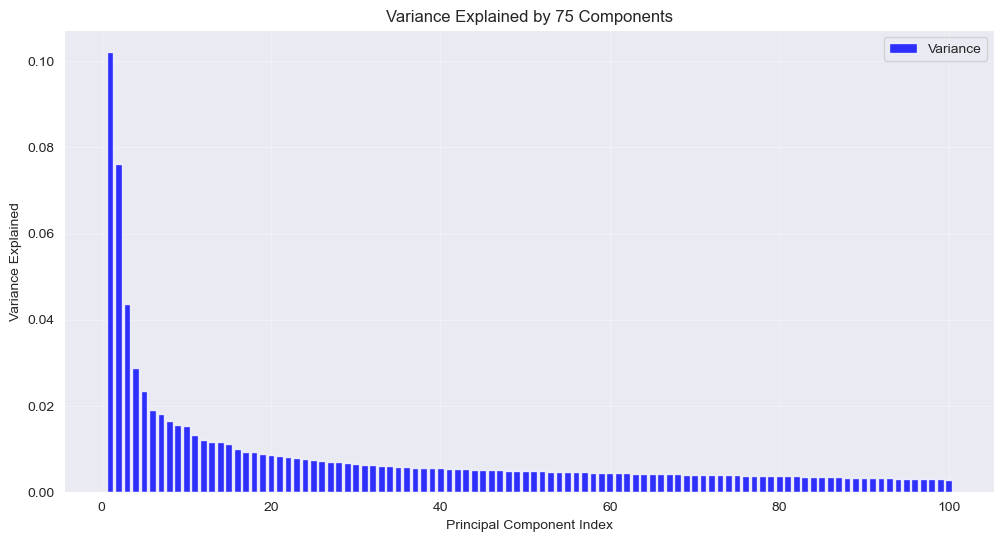

In [10]:

# Apply PCA
pca = PCA(n_components=100)
pca.fit(nhanes_scaled)

# Attributes
explained_variance_ratio = pca.explained_variance_ratio_
cumulative_variance = np.cumsum(explained_variance_ratio)
components = pca.components_
explained_variance = pca.explained_variance_
singular_values = pca.singular_values_

# Attributes -- doesn't help to look at them. I have no idea what I'm doing
print("Explained Variance Ratio (each component):", explained_variance_ratio)
print("Cumulative Explained Variance:", cumulative_variance)
print("Principal Components (Eigenvectors):", components)
print("Explained Variance (absolute):", explained_variance)
print("Singular Values:", singular_values)

# bar plot
plt.figure(figsize=(12, 6))
plt.bar(range(1, 101), explained_variance_ratio, alpha=0.8, color='blue', label='Variance')
plt.xlabel('Principal Component Index')
plt.ylabel('Variance Explained')
plt.title('Variance Explained by 75 Components')
plt.grid(alpha=0.3)
plt.legend()
plt.show()


In [11]:
# Get the cumulative explained variance
cumulative_variance = np.cumsum(pca.explained_variance_ratio_)


# Find the number of components that explain at least 80% variance
n_components_80 = np.argmax(cumulative_variance >= 0.80) + 1
print(n_components_80)

86


### How many components will you use to fit a supervised learning model?

I should be looking to choose the number of PCs that yeilds the best model performance with the classic balance between overfitting and underfitting. Using the attributes, it would appear that I need to keep 86, but that seems crazy since we kept two in class. 

### 2D Scatterplot of the first two components

In [12]:
nhanes_scaled_target['HSD010_binary']

SEQN
73568    good
73576    good
73579    good
73581    good
73584    good
         ... 
83694    good
83696    good
83704    poor
83716    good
83721    good
Name: HSD010_binary, Length: 2064, dtype: object

In [13]:

# # PCA 2
# pca = PCA(n_components=2)
# X_pca_2d = pca.fit_transform(nhanes_scaled_target)

# # df
# pca_df = pd.DataFrame(data=X_pca_2d, columns=['PC 1', 'PC 2'])

# #adding in the target???
# pca_df['target'] = nhanes_scaled_target['HSD010_binary']  # I saved this above in desperation 

# # plot
# plt.figure(figsize=(10, 8))
# plt.scatter(pca_df['PC 1'], pca_df['PC 2'], 
#             c=pca_df['target'], cmap='viridis', alpha=0.7)

# # extras
# plt.title('PCA with Target')
# plt.xlabel('PC 1')
# plt.ylabel('PC 2')

# # target colrs
# plt.colorbar(label='HSD010_binary')

# #This box represents probably three hours of experimenting with trying to get the target to
# appear in the scatterplot and I just can't figure out how to do it. All blue it is!


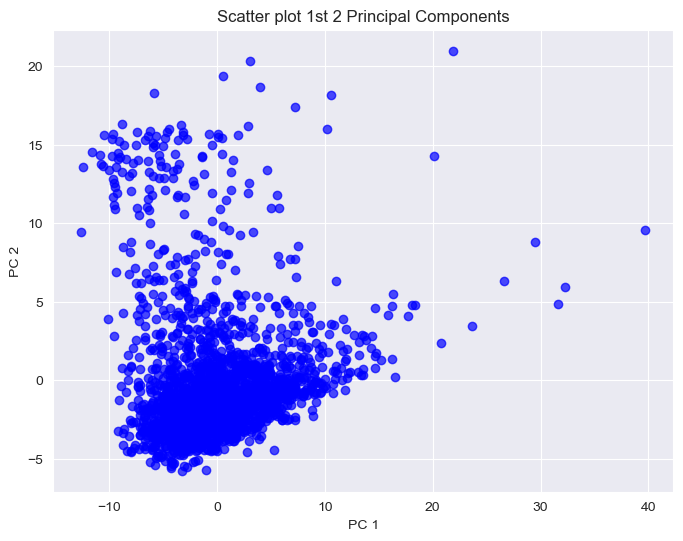

In [14]:
#Here's a scatter plot without the color coded target. 
pca = PCA(n_components=2)
X_pca_2d = pca.fit_transform(nhanes_scaled)  # Replace nhanes_scaled with your data

# Scatter plot
plt.figure(figsize=(8, 6))
plt.scatter(X_pca_2d[:, 0], X_pca_2d[:, 1], alpha=0.7, color='blue')
plt.title('Scatter plot 1st 2 Principal Components')
plt.xlabel('PC 1')
plt.ylabel('PC 2')
plt.grid(True)
plt.show()



Ok, so we're seeing most points concentrated near the lower-left. Maybe most of the data is pretty similar? Or has similar values for the features in the first two principal components? So not much variability in those components....There's a little bit of spread upward along PC2,  indicating that variability exists to some degree along this second component; in other words, there is variability in the dataset based on factors captured by PC2. There's a little bit ofspread to the right along PC1 but the variation in PC1 appears less pronounced than PC2.

## K-Means

- Choose a clustering algorithm and explain it in 1-2 sentences.
- Cluster the nhanes data. Detail any choice you need to make with regards to number of clusters, and how you arrived at that choice. For instance, you might use the [elbow method](https://en.wikipedia.org/wiki/Elbow_method_(clustering)) if you choose k-means.
- Plot your clusters on top of BMI v. Income Poverty Ratio Plot. Describe what you see in 1-2 sentences.
- Retrain the clustering algorithm, but this time use your PCA results instead of the original dataframe. Plot the clusters on top of the 2D PCA scatterplot from the previous step. Describe your results in 1-2 sentences.

### Choose a Clustering Algorithm

K-Means is a clustering algorithm that groups data into clusters k based on similarity. The algorithm assigns each data point to the nearest cluster center, then recalculates the cluster centers and repeats the process until the clusters are stable.

In class we did the elbow method, which is a technique used in clustering to determine the optimal number of clusters (k) for k-means and the like.You plot how the sum of differences within clusters changes as you increase the number of clusters, and look for a point where the curve starts to flatten—this is the "elbow" and suggests the best k. 

### Cluster nhanes

C:\Users\mackgsr1nvivo\anaconda3\envs\CSS\Lib\site-packages\sklearn\cluster\_kmeans.py:1446: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=9.
  warnings.warn(
C:\Users\mackgsr1nvivo\anaconda3\envs\CSS\Lib\site-packages\sklearn\cluster\_kmeans.py:1446: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=9.
  warnings.warn(
C:\Users\mackgsr1nvivo\anaconda3\envs\CSS\Lib\site-packages\sklearn\cluster\_kmeans.py:1446: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=9.
  warnings.warn(
C:\Users\mackgsr1nvivo\anaconda3\envs\CSS\Lib\site-packages\sklearn\cluster\_kmeans.p

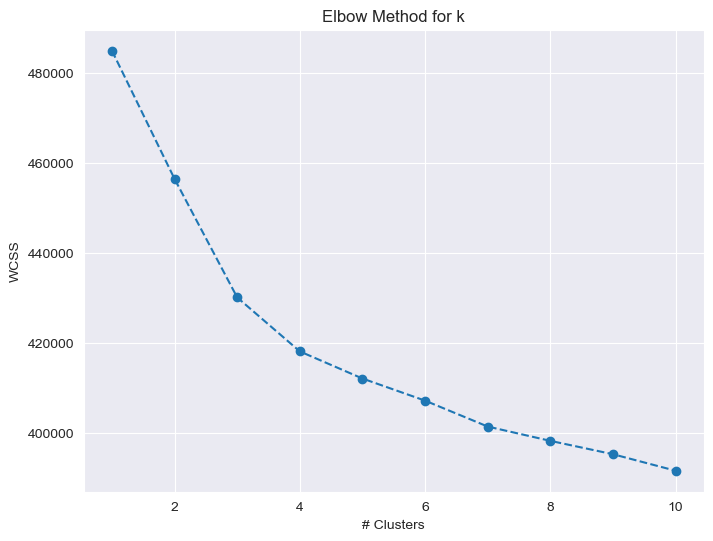

C:\Users\mackgsr1nvivo\anaconda3\envs\CSS\Lib\site-packages\sklearn\cluster\_kmeans.py:1446: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=9.
  warnings.warn(


In [15]:
# Elbow
wcss = []
for k in range(1, 11):
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(nhanes_scaled)
    wcss.append(kmeans.inertia_)

# Plot
plt.figure(figsize=(8, 6))
plt.plot(range(1, 11), wcss, marker='o', linestyle='--')
plt.title('Elbow Method for k')
plt.xlabel('# Clusters')
plt.ylabel('WCSS')
plt.show()

# cluster choosing
optimal_k = 4
kmeans = KMeans(n_clusters=optimal_k, random_state=42)
kmeans.fit(nhanes_scaled)
labels = kmeans.labels_


In [16]:
## Based on the elbow method, I'm thinking four clusters make sense. Relieved that this method makes so much more sense than PCA. 

### Plot your clusters on top of the BMI v. Income Poverty Ratio Plot

C:\Users\mackgsr1nvivo\anaconda3\envs\CSS\Lib\site-packages\sklearn\cluster\_kmeans.py:1446: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=9.
  warnings.warn(
C:\Users\mackgsr1nvivo\AppData\Local\Temp\ipykernel_35836\533153203.py:7: UserWarning: Ignoring `palette` because no `hue` variable has been assigned.
  ax = sns.scatterplot(x = "INDFMPIR", y = "BMXBMI", palette = "tab10", data = nhanes_scaled)


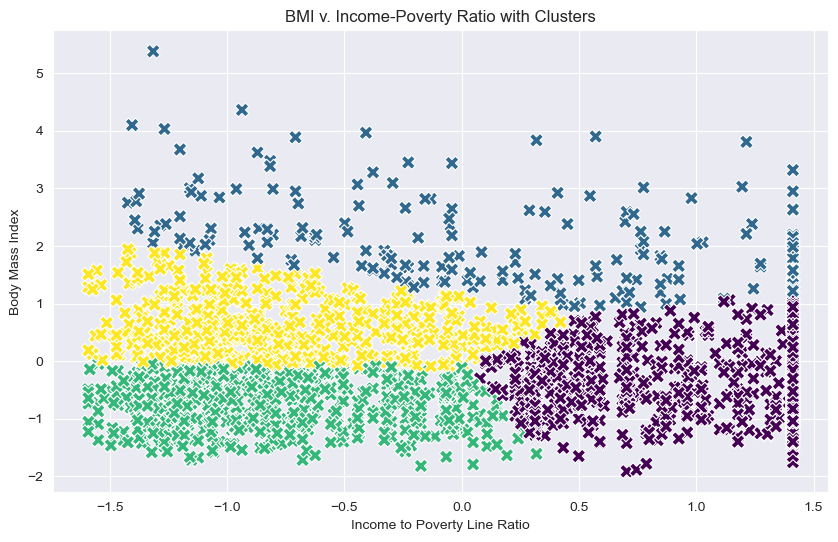

In [25]:
# clustering
kmeans = KMeans(n_clusters=4, random_state = 10) 
nhanes_scaled['cluster'] = kmeans.fit_predict(nhanes_scaled[['INDFMPIR', 'BMXBMI']])

#  original scatter plot 
plt.figure(figsize=(10, 6))
ax = sns.scatterplot(x = "INDFMPIR", y = "BMXBMI", palette = "tab10", data = nhanes_scaled)

##need to remove hue of HSD010 because we took that out of the dataset. right? 

# Overlay the clusters
sns.scatterplot(x = "INDFMPIR", y = "BMXBMI", hue = "cluster", palette="viridis", data=nhanes_scaled, marker="X", s=100, legend=False)

# labels etc
ax.set(xlabel = "Income to Poverty Line Ratio", ylabel = "Body Mass Index")
ax.set_title("BMI v. Income-Poverty Ratio with Clusters")

# Show the plot
plt.show()


Ok, so the cluster colors are concentrated almost exactly in the four quadrants. This suggests that the clusters are highly related to the combinations of BMI and Income-Poverty Ratio we're looking at here... Yellow, in the upper left, indicates higher BMI and lower income (a large-ish group with a lot of vertical spread); purple in the upper right have higher BMI and higher income; green, lower-right quadrant, represents lower BMI with higher income, and the blue in the lower-left shows lower BMI and lower income. This tells me that there are definite relationships between socioeconomic status and body mass in the data.

Edit: I didn't set a random state and then when I reran this code everything looks different! fixing now, the new description is as follows: 
Blue is floating along the top, and group of high-BMI observations that span the SES spectrum
yellow is a group with low-income and average BMI.
Green is low income and low BMI. 
Purple is high income and low BMI. 
Still definite relationships between socioeconomic status and body mass in the data, but it's perturbing to me how much this changes with a different random state. 

### Retrain the clustering algorithm on PCA components and plot clusters on your 2D scatter

In [19]:
# Full disclosure I do not understand how to choose a small number of components, given my exploration of PCA attributes told me I needed 
# 86. 86 and 2 are just quite far away, so I know I'm missing something but I'm a little too busy and stressed to work on it any more. 
# I thought maybe there would be some opportunity later for trial and error but no dice. I'm just going to use two here.

C:\Users\mackgsr1nvivo\anaconda3\envs\CSS\Lib\site-packages\sklearn\cluster\_kmeans.py:1446: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=9.
  warnings.warn(


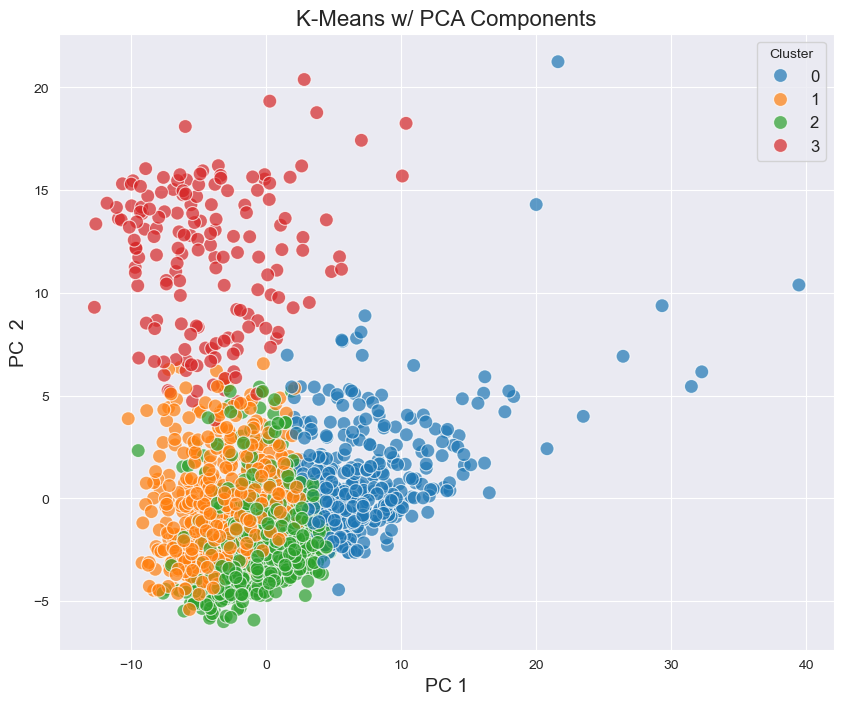

In [26]:
# PCA with two components.
pca = PCA(n_components=2) 
X_pca = pca.fit_transform(nhanes_scaled) 

# fitting kmanes
kmeans = KMeans(n_clusters=4, random_state=10)  #4 clusters worked well.
kmeans.fit(X_pca)

# plotting the clusters onto PCA
plt.figure(figsize=(10, 8))
sns.scatterplot(x=X_pca[:, 0], y=X_pca[:, 1], hue=labels, palette="tab10", s=100, alpha=0.7)

# titles etc
plt.title("K-Means w/ PCA Components", fontsize=16)
plt.xlabel("PC 1", fontsize=14)
plt.ylabel("PC  2", fontsize=14)
plt.legend(title="Cluster", loc="best", fontsize=12) #fancy legend
plt.grid(True)
plt.show()


Again this changed significantly with the new random state -- much less clear delineations between clusters.  

Kind of neat to see how the clusters interact with the two PCs. I wish I understood the contents of the clusters and PCs better, or knew how to access them, so that I could draw some kind of theoretical conclusions. If I have time I'll do some brute forcing to try and figure that out. But in terms of what the scatterplot shows, I'm seeing four clusters (blue, orange, green, and red) with a fair amount of overlap, particularly in the central regions of the plot and around the lower left quadrant). TheSo there is separation between the groups, but the boundaries between clusters are not sharply defined in the PC1-2 space.

The red cluster is sitting at higher values of PC2. The orange cluster dominates the lower-left region, features associated with lower values of both PC1 and PC2 compared to other individuals, but with balanced contributions from PC1 and PC2. Semi-mixed with the orange, I'm seeing the green cluster on kind of the lower right side, extending around the 0 value for PC1. Green and orange and red all have a fair amount of negative PC1 values. 

The blue cluster is quite different; it occupies the far-right region, spreads very  broadly to the right, and doesn't have any negative PC1 values. 

The spread along the PC1 axis suggests variability related to one major component of the dataset, while PC2 captures another. PCA is supposed to capture most of the variance, but in my analyses I could only see it doing that when I included like 50+ components. Pretty confused about all that still. 

## Neural Network

Now we are ready to predict! Do the following:

- Choose either HSD010 or HSD010\_binary as your target outcome.  
- Train a neural network using the original features. Much of the code to train a basic neural net has been set up for you, but you will need to fill in a couple of missing pieces.
- Train a neural network using only your PCA components as features.
- Train a neural network using your PCA components and the predicted class membership from your clustering algorithm as features.
- Compare and contrast how well each algorithm did. Which featurization technique would you pick and why?

Below we provide a template for training a neural network. Use this template for training on the original features, on the PCA components, and the PCA components + the predicted classes from your clusters.

### Neural Network on Original Features

In [54]:
hsd010_binary
tabulation = hsd010_binary.value_counts()
print(tabulation)

HSD010
good    1732
poor     332
Name: count, dtype: int64


In [68]:
hsd010_binary_numeric = hsd010_binary.map({'good': 0, 'poor': 1})


In [69]:
hsd010_binary_numeric
tabulation = hsd010_binary_numeric.value_counts()
print(tabulation)

HSD010
0    1732
1     332
Name: count, dtype: int64


In [70]:
# partition data
# -----------
X =  nhanes_scaled
y =  hsd010_binary_numeric  # either hsd010 or hsd010_binary, may need to convert to numeric if it isn't already 
## drop out any columns that aren't features: I don't know how to know what columns are and are not features -- 
## PCA and clustering are so opaque to me. Or do you mean just drop y? Hmm 


X_train, X_test, y_train, y_test = train_test_split(X, 
                                                    y, 
                                                    test_size = .25, 
                                                    random_state = 10)

In [71]:
# # load libraries
# # -----------
# import keras
# from keras.utils import to_categorical

##chat gpt tells me this code is one-hot-encoding. The code below only works if I comment this out. 

# num_classes = 2
# # convert class vectors to binary class matrices
# y_train = keras.utils.to_categorical(y_train, num_classes)
# y_test = keras.utils.to_categorical(y_test, num_classes)
# num_classes = y_test.shape[1] #why is this down here and not above????

In [73]:
# create neural network model
# -----------
model = Sequential()

#google
#input
model.add(Dense(64, input_dim=242, kernel_initializer='he_normal', activation='relu')) 
#hidden
model.add(Dense(32, kernel_initializer='he_normal', activation='relu')) 
#output
model.add(Dense(1, activation='softmax')) 
## Add any additional layers you wish here. I'm not gettin this enough to know whether and why I would do that sorry
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

model.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=20, batch_size=32, verbose=1)


Epoch 1/20


C:\Users\mackgsr1nvivo\anaconda3\envs\CSS\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
C:\Users\mackgsr1nvivo\anaconda3\envs\CSS\Lib\site-packages\keras\src\ops\nn.py:545: UserWarning: You are using a softmax over axis -1 of a tensor of shape (None, 1). This axis has size 1. The softmax operation will always return the value 1, which is likely not what you intended. Did you mean to use a sigmoid instead?
  warnings.warn(
C:\Users\mackgsr1nvivo\anaconda3\envs\CSS\Lib\site-packages\keras\src\losses\losses.py:27: SyntaxWarning: In loss categorical_crossentropy, expected y_pred.shape to be (batch_size, num_classes) with num_classes > 1. Received: y_pred.shape=(None, 1). Consider using 'binary_crossentropy' if you only have 2 class

38/49 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.1600 - loss: 0.0000e+00

C:\Users\mackgsr1nvivo\anaconda3\envs\CSS\Lib\site-packages\keras\src\ops\nn.py:545: UserWarning: You are using a softmax over axis -1 of a tensor of shape (None, 1). This axis has size 1. The softmax operation will always return the value 1, which is likely not what you intended. Did you mean to use a sigmoid instead?
  warnings.warn(
C:\Users\mackgsr1nvivo\anaconda3\envs\CSS\Lib\site-packages\keras\src\losses\losses.py:27: SyntaxWarning: In loss categorical_crossentropy, expected y_pred.shape to be (batch_size, num_classes) with num_classes > 1. Received: y_pred.shape=(None, 1). Consider using 'binary_crossentropy' if you only have 2 classes.
  return self.fn(y_true, y_pred, **self._fn_kwargs)


49/49 ━━━━━━━━━━━━━━━━━━━━ 4s 14ms/step - accuracy: 0.1613 - loss: 0.0000e+00 - val_accuracy: 0.1512 - val_loss: 0.0000e+00
Epoch 2/20
49/49 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.1601 - loss: 0.0000e+00 - val_accuracy: 0.1512 - val_loss: 0.0000e+00
Epoch 3/20
49/49 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.1806 - loss: 0.0000e+00 - val_accuracy: 0.1512 - val_loss: 0.0000e+00
Epoch 4/20
49/49 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.1649 - loss: 0.0000e+00 - val_accuracy: 0.1512 - val_loss: 0.0000e+00
Epoch 5/20
49/49 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.1606 - loss: 0.0000e+00 - val_accuracy: 0.1512 - val_loss: 0.0000e+00
Epoch 6/20
49/49 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.1382 - loss: 0.0000e+00 - val_accuracy: 0.1512 - val_loss: 0.0000e+00
Epoch 7/20
49/49 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.1664 - loss: 0.0000e+00 - val_accuracy: 0.1512 - val_loss: 0.0000e+00
Epoch 8/20
49/49 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.1633 - l

In [74]:
# Evaluate the model on test data
loss, accuracy = model.evaluate(X_test, y_test, verbose=1)

# Print the results
print(f"Test Loss: {loss}")
print(f"Test Accuracy: {accuracy}")


17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.1508 - loss: 0.0000e+00
Test Loss: 0.0
Test Accuracy: 0.151162788271904


This is pretty weird. I think it's a bad model and overfitte

### Neural Network on Principal Components

In [ ]:
## Your Answer Here

### Neural Network on Principal Components + Cluster Membership

In [ ]:
## Your Answer Here

## Discussion Questions

1. In your own words, what is the difference between PCA and clustering?

Principal Component Analysis (PCA) is a technique to reduce dimensionality, shrinking the data down to the most important parts. By reducing the number of features in the data to the principal components, PCA makes it easier to process and understand. Clustering is also a simplifying technique but  instead of reductions it simplifies by sorting data into groups of similar things, finding which features go together, and identifying patterns or groupings. PCA simplifies the data by reducing its complexity, while clustering identifies patterns or groupings within the it.

2. Did you notice any advantages to combining PCA and clustering? If so, what do you think they were? If not, why do you think you didn't see any gains from this combination?

## Your Answer Here

3. How can unsupervised techniques help with downstream supervised learning tasks when working with "big data?"

Unsupervised techniques like PCA and clustering help with supervised learning by reducing noise, simplifying data structures, and creating new features that capture key patterns. This kind of preprocessing makes it easier for supervised algorithms to be trained and to perform well, especially when the raw data is messy, highly dimensional, or overwhelming in size. Unsupervised techniques can give supervised models a clearer roadmap to follow. For instance, clustering can reveal underlying patterns  by grouping similar datapoints, creating more meaningful labels for supervised analyses. 